#   Borrower default rate prediction

### Develop a model that predicts how likely it is for a borrower to default

#### Function to run multiple classifiers on same training/test sets

In [92]:
## Import sklearn packages for model building
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

def run_models(X_train, y_train, X_test, y_test, clfs, model_type='Balanced'):
    '''
    This function takes as inputs the training and test data (X_train, y_train, X_test, y_test), the sklearn 
    classifiers to use (as name:method signature dict), and a model_type label to indicate if the data is 
    class balanced. It returns a data frame containing some performance metrics for each classifier and a 
    dict of confusion matrices (name:confusion matrix) for each classifier. It also plots the ROC curve for
    each classifier.
    
    The sklearn classifiers that have been imported and tested including Linear and LogisticRegression, 
    GaussianNB, RandomForestClassifier, GradientBoostingClassifier, SVC, LinearSVC, Neural Networks.
    
    Example:
    model_type = 'Non-balanced'
    clfs = {
            'LogisticRegression' : LogisticRegression(),
            'SVM': LinearSVC(C=1.0) 
            }

    report, conf_matrix = run_models(X_train, y_train, X_test, y_test, clfs, model_type)
    '''
    
    
    ## Columns for performance metrics table 
    cols = ['Model','Matthews_CorrCoef', 'Roc_Auc_Score', 'Precision', 'Recall','F1']
    models_report = pd.DataFrame(columns = cols)
    
    ## Confusion Matrix initialization
    conf_matrix = dict()

    ## Fit model for each classifier type and compute performance metrics
    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        print('Computing {} - {} '.format(clf_name, model_type))

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test)[:,1]
        elif hasattr(clf, "decision_function"): 
            y_score = clf.decision_function(X_test)
            y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
        else:
            y_score = np.where(y_pred<0,0,np.where(y_pred>1,1,y_pred))
            y_pred = np.where(y_pred<0.5,0,1)
        
        
        tmp = pd.Series({'Model_Type': model_type,
                         'Model': clf_name,
                         'Roc_Auc_Score' : metrics.roc_auc_score(y_test, y_score),
                         'Matthews_CorrCoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'Precision': metrics.precision_score(y_test, y_pred),
                         'Recall': metrics.recall_score(y_test, y_pred),
                         'F1': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = confusion_matrix(y_test, y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(7,7))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc="lower right", prop={'size':11})


    plt.plot([0,1],[0,1], color = 'black')

    return models_report, conf_matrix

#### Function to plot confusion matrix

In [2]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    '''
    This function takes as inputs the confusion matrix (from sklearn.metrics.confusion_matrix) and a 
    list of class names, and prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    title and color map can be set as well.
    
    Example:
    
    class_names = ["Current","Default"]

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(conf_matrix['LogisticRegression'], classes=class_names,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(conf_matrix['LogisticRegression'], classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    '''
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()


#### READ DATA

Data files have been 'cleaned' using shell scripts so that they are nicely delimited and readable.
There are multiple data files that are being read and concatenated into single Pandas data frame.

In [73]:
## READ DATA
import pandas as pd
import numpy as np

periods = ['2016Q1','2016Q2','2016Q3','2016Q4','2017Q1','2017Q2','2017Q3'] 
cols_to_keep = ['application_type','fico_range_high','grade','loan_status','loan_amnt','purpose','annual_inc','total_bal_ex_mort','all_util','revol_util','dti','emp_length','term','int_rate','issue_d','last_pymnt_d','total_rec_prncp','total_rec_late_fee','earliest_cr_line','mths_since_last_delinq','mths_since_last_major_derog','acc_open_past_24mths','inq_last_6mths']
data = pd.concat([pd.read_csv("LoanStats_{}.csv".format(period),sep="|",header=0,usecols=cols_to_keep) for period in periods], ignore_index=True, verify_integrity=True)

## Memory used in MB
data.memory_usage().sum()/1e6

139.71827200000001

#### CLEAN DATA & ENGINEER FEATURES

In [74]:
## Keep only Individual Application types -- joint applications have different columns
data = data[data.application_type=='Individual']

## Convert loan_amnt to float for normalizations
data['loan_amnt'] = data['loan_amnt'].astype('float')

## Convert emp_length to numeric from string
data['emp_length'] = data['emp_length'].str.extract('(\d+)').astype(float)
data['emp_length'].fillna(value=0.0,inplace=True)

## Convert term to integer
data['term'] = data['term'].str.split(' ').str[1]

## Convert int_rate to a float
data['int_rate'] = data['int_rate'].str.split('%').str[0]
data['int_rate'] = data.int_rate.astype(float)/100.0

## Compute dti_rate (estimate) and set red flag if it is not as high as interest rate on current loan
data['dti_rf']=np.where(0.01*data['dti']*data['annual_inc']/data['total_bal_ex_mort']<data['int_rate']+0.16,1,0)

## Compute length of credit history at loan issue
data['credit_hist_length'] = (pd.to_datetime(data['issue_d'],format="%b-%Y") - pd.to_datetime(data['earliest_cr_line'],format="%b-%Y")).dt.days/365

## Compute period before loan became delinquent
data['period_non_delinq'] = (pd.to_datetime(data['last_pymnt_d'],format="%b-%Y") - pd.to_datetime(data['issue_d'],format="%b-%Y")).dt.days/365

## Normalize total principal received
data['frac_rec_prncp'] = data['total_rec_prncp']/data['loan_amnt']

## Categorize if borrower was ever late in loan payments
data['never_late'] = np.where(data['total_rec_late_fee']>0,0,1)

## Categorize if borrower was ever delinquent in last 2yrs, or had a major derogatory in credit report
data['never_delinq'] = np.where(pd.notna(data['mths_since_last_delinq']) & data['mths_since_last_delinq']>0,0,1)
data['never_derog'] = np.where(pd.notna(data['mths_since_last_major_derog']) & data['mths_since_last_major_derog']>0,0,1)

## Delete columns not needed any more
delete_cols = ['annual_inc','int_rate','total_bal_ex_mort','application_type','earliest_cr_line','last_pymnt_d','mths_since_last_delinq','mths_since_last_major_derog','total_rec_late_fee','total_rec_prncp']
data.drop(delete_cols , axis=1, inplace=True)

## Set up features list for later model building
features = ['never_late','frac_rec_prncp','fico_range_high','acc_open_past_24mths','never_delinq','never_derog','inq_last_6mths','credit_hist_length','emp_length','dti','dti_rf']

## Categorize based on loan purpose
loan_purpose_list = ['car','credit_card','debt_consolidation','home_improvement','major_purchase','medical','moving','small_business','vacation']
for purpose in loan_purpose_list:
    colname = purpose+'_loan'
    data[colname] = np.where(data['purpose']==purpose,1,0)
    features.append(colname)
    
loan_purpose_list.append('other')
data['other_loan'] = np.where(data['purpose'].isin(loan_purpose_list),0,1)
features.append('other_loan')

## Delete columns not needed any more
delete_cols = ['issue_d','purpose']
data.drop(delete_cols , axis=1, inplace=True)

## Create new loan delinquent column based on loan_status
data['loan_delinq']=np.where(data['loan_status'].isin(["Current","Fully Paid","In Grace Period"]),0,np.where(data['period_non_delinq']>1.05,0,1))
features.insert(0,'loan_delinq')

## Group by loan delinquency and get sizes
data.groupby("loan_delinq").size()

/home/pallav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


loan_delinq
0    686752
1     38583
dtype: int64

#### INVESTIGATE & VISUALIZE FEATURE DISTRIBUTION

Drop rows in data that have NA.
Split data into X and y.
Examine feature summary distribution.
Graph feature distribution.

In [75]:
## Drop rows of data where features have NA (only 1)
X = data[features]
X.dropna(axis=0, how = 'any', inplace = True)

y = X['loan_delinq']
X=X[features[1:]]
print(len(X))

725334


/home/pallav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
X.describe()

,never_late,frac_rec_prncp,fico_range_high,acc_open_past_24mths,never_delinq,never_derog,inq_last_6mths,credit_hist_length,emp_length,dti,...,car_loan,credit_card_loan,debt_consolidation_loan,home_improvement_loan,major_purchase_loan,medical_loan,moving_loan,small_business_loan,vacation_loan,other_loan
count,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,...,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000,725334.000000
mean,0.977834,0.390767,700.371028,4.714883,0.477642,0.715102,0.542954,16.632075,5.726543,18.390939,...,0.011785,0.208697,0.564781,0.075656,0.024500,0.013617,0.007976,0.011013,0.008677,0.005424
std,0.147224,0.320883,32.034800,3.285113,0.499500,0.451366,0.842565,7.734689,3.780203,8.340151,...,0.107917,0.406378,0.495786,0.264447,0.154597,0.115895,0.088950,0.104363,0.092747,0.073446
min,0.000000,0.000000,664.000000,0.000000,0.000000,0.000000,0.000000,3.079452,0.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.140102,674.000000,2.000000,0.000000,0.000000,0.000000,11.421918,2.000000,12.140000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.279867,694.000000,4.000000,0.000000,1.000000,0.000000,15.010959,5.000000,17.950000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.530509,714.000000,6.000000,1.000000,1.000000,1.000000,20.597260,10.000000,24.390000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,850.000000,61.000000,1.000000,1.000000,5.000000,83.309589,10.000000,49.960000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/home/pallav/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


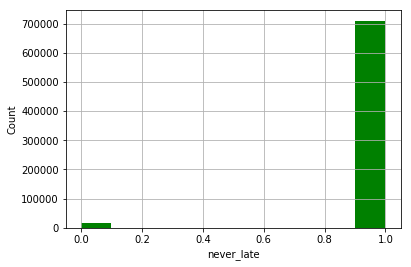

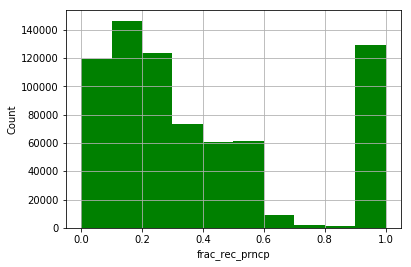

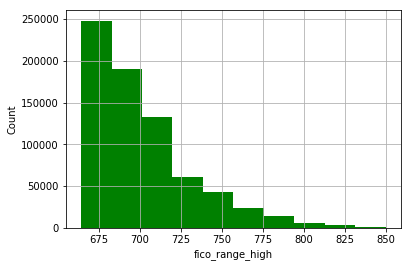

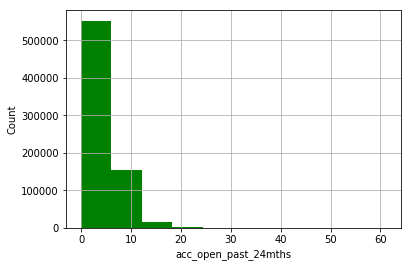

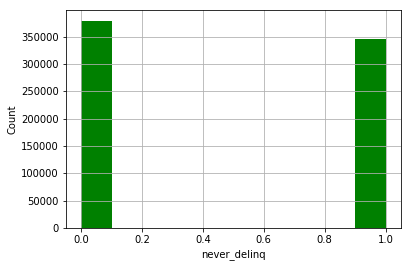

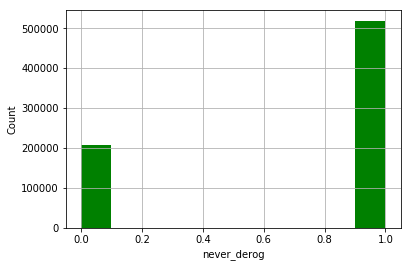

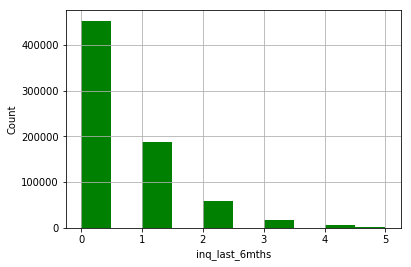

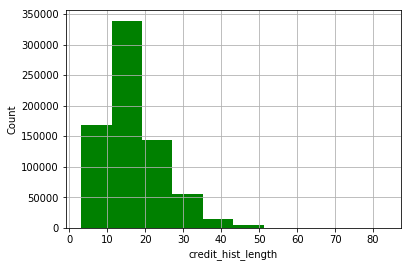

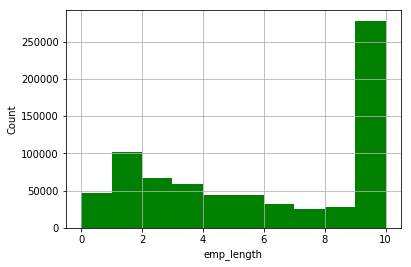

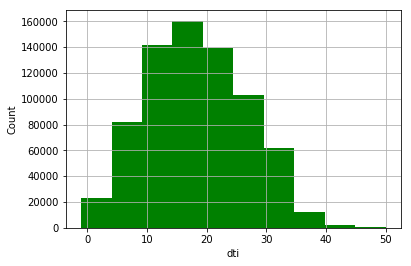

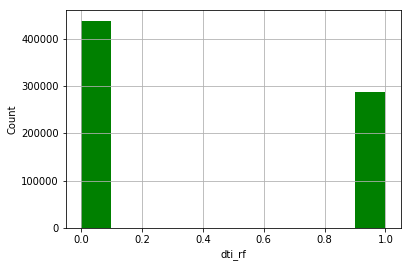

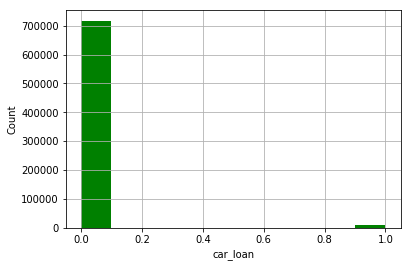

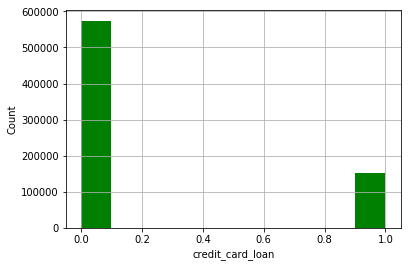

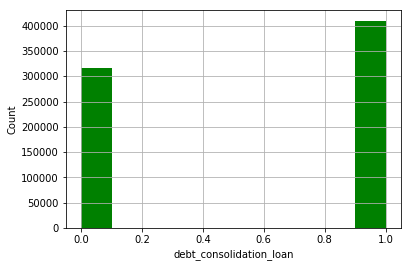

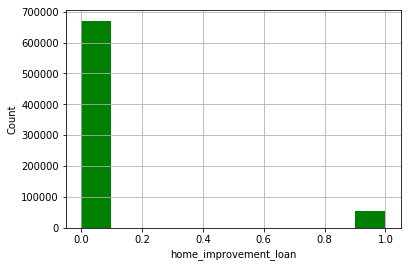

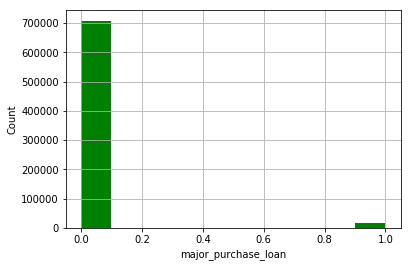

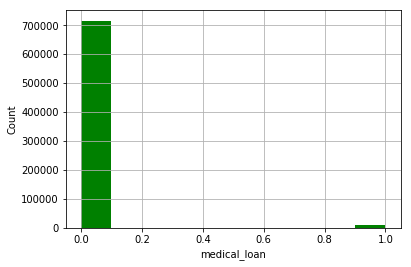

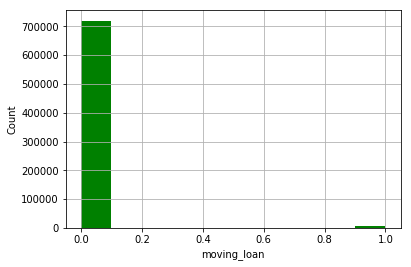

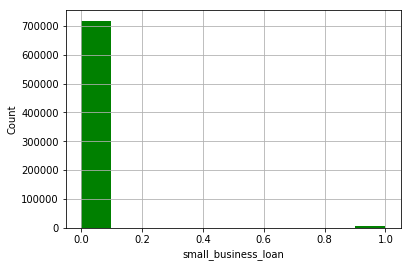

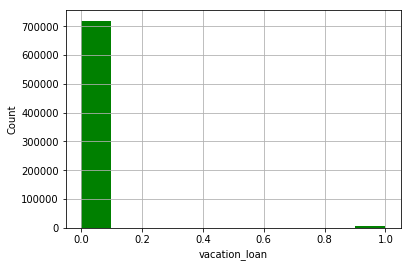

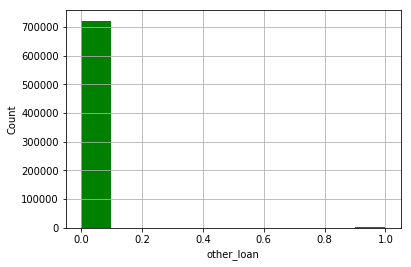

In [77]:
## Graph input data

for i in range(1,len(features)):
    col = features[i]
    #print(col)
    
    ## Histogram
    plt.figure(i+1)
    plt.hist(X[col],density=False,color='g')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.grid(True)
        
plt.show()

#### EXAMINE CORRELATION & VIF

In [78]:
data[features].corr()

,loan_delinq,never_late,frac_rec_prncp,fico_range_high,acc_open_past_24mths,never_delinq,never_derog,inq_last_6mths,credit_hist_length,emp_length,...,car_loan,credit_card_loan,debt_consolidation_loan,home_improvement_loan,major_purchase_loan,medical_loan,moving_loan,small_business_loan,vacation_loan,other_loan
loan_delinq,1.000000,-0.114574,-0.194844,-0.066822,0.073133,-0.005533,-0.013717,0.064463,-0.023668,-0.023559,...,-0.007212,-0.024840,0.014956,-0.006854,0.002372,0.006075,0.006373,0.015134,-0.001046,0.005833
never_late,-0.114574,1.000000,0.017563,0.043526,-0.014989,0.035181,0.023017,-0.023955,0.007964,0.003885,...,0.002731,0.018191,-0.000386,-0.004377,-0.006244,-0.001944,-0.005450,-0.014530,-0.001664,-0.004054
frac_rec_prncp,-0.194844,0.017563,1.000000,0.047821,0.044579,0.002524,0.000905,0.022251,-0.002123,0.006930,...,0.008467,0.007364,-0.016505,0.005603,0.008341,-0.002558,0.003074,-0.007558,0.002299,0.008223
fico_range_high,-0.066822,0.043526,0.047821,1.000000,-0.108236,0.307107,0.282276,-0.095250,0.106835,0.024246,...,0.024615,-0.003707,-0.073927,0.076725,0.049917,0.007906,-0.000656,0.015715,0.009211,0.011871
acc_open_past_24mths,0.073133,-0.014989,0.044579,-0.108236,1.000000,-0.052620,-0.090736,0.307614,-0.030186,0.030861,...,-0.017662,-0.026701,0.032690,0.022270,-0.014307,-0.003527,-0.014761,-0.012926,0.006591,-0.000848
never_delinq,-0.005533,0.035181,0.002524,0.307107,-0.052620,1.000000,0.559615,-0.042849,-0.130869,-0.044015,...,0.000080,0.049526,-0.018740,-0.026491,0.000907,-0.005136,-0.001898,-0.006041,0.000259,-0.005676
never_derog,-0.013717,0.023017,0.000905,0.282276,-0.090736,0.559615,1.000000,-0.084575,-0.106218,-0.019074,...,0.000518,0.048250,-0.019013,-0.020975,-0.001088,-0.003112,-0.001060,-0.004485,-0.000720,-0.008202
inq_last_6mths,0.064463,-0.023955,0.022251,-0.095250,0.307614,-0.042849,-0.084575,1.000000,0.005254,0.001195,...,-0.004036,-0.020659,-0.003270,0.023462,0.007929,0.001105,0.001693,0.012980,0.006151,0.007753
credit_hist_length,-0.023668,0.007964,-0.002123,0.106835,-0.030186,-0.130869,-0.106218,0.005254,1.000000,0.122810,...,-0.011685,0.010930,-0.002766,0.042056,-0.024108,0.010022,-0.026204,-0.006785,-0.010780,-0.013373
emp_length,-0.023559,0.003885,0.006930,0.024246,0.030861,-0.044015,-0.019074,0.001195,0.122810,1.000000,...,-0.009143,-0.024438,0.018280,0.036388,-0.015503,-0.004469,-0.031846,-0.004371,0.004758,-0.006928


In [79]:
## VIF

xtx_inv = np.linalg.inv(np.matmul(np.transpose(X),X))
x_var = [np.var(X.iloc[:,i]) for i in range(len(features)-1)]
vif = [len(X)*x_var[i]*xtx_inv[i,i] for i in range(len(features)-1)]

for i in range(len(features)-1):
    print(vif[i])

0.947592163933
1.00868296884
0.147029597198
1.14927473306
1.48214147687
1.49639524763
1.11092624156
1.07285141846
1.02509471416
1.03920620557
1.02973372837
1.15834173944
3.16528074828
3.9600496075
1.95718440184
1.32779889521
1.18044595087
1.10658065379
1.1477092967
1.11631152983
1.07348424277


#### PREPARE DATA FOR MODEL BUILDING

Scale (normalize) X data.
Split into training and test sets.
Oversample if class balancing needed.

In [83]:
## Scale data
from sklearn import preprocessing

X_scaled = preprocessing.scale(X)
len(X)

725334

In [86]:
## Split data into train/test sets
from sklearn.model_selection import train_test_split #, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.25, random_state=0)

print(len(X_train))
print(len(y_train))
print(sum(y_train))

print(len(X_test))
print(len(y_test))

544000
544000
28869
181334
181334


In [82]:
## Oversample the training data using SMOTE package if model_type is `Balanced`
from imblearn.over_sampling import SMOTE

#model_type = 'Non-balanced'
model_type = 'Balanced'

if model_type == 'Balanced':
    X_train, y_train = SMOTE().fit_sample(X_train, y_train)

print(len(y_train))
print(sum(y_train))

1030262
515131


#### BUILD MODELS

Prepare models for different classifiers.
Graph the ROC curve for each classifier over test data.
Compare performance metrics for each classifier over test data.
Compare confusion matrix for each classifier over test data.

Computing LogisticRegression - Balanced 
Computing DecisionTree - Balanced 
Computing NaiveBayes - Balanced 
Computing GradientBoosting - Balanced 
Computing RandomForest - Balanced 
Computing SVM - Balanced 
Computing NeuralNetwork - Balanced 


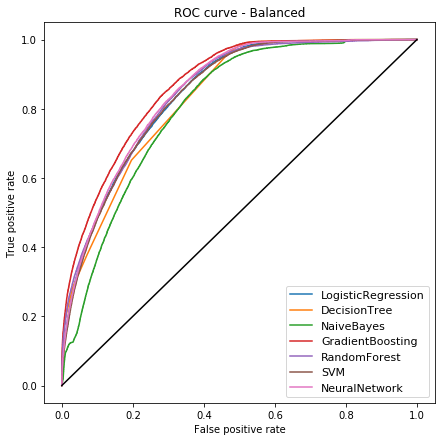

In [89]:
## Set up classifiers and run models
clfs = {
        'LogisticRegression' : LogisticRegression(),
        'DecisionTree': DecisionTreeClassifier(max_depth=20), 
        'NaiveBayes': GaussianNB(),
        'GradientBoosting': GradientBoostingClassifier(max_depth=6, n_estimators=100, max_features = 0.3),
        'RandomForest': RandomForestClassifier(max_depth=6, n_estimators=100),
        'SVM': LinearSVC(C=1.0),
        'NeuralNetwork': MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1),
        }

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, clfs, model_type)

In [90]:
models_report

,Model,Matthews_CorrCoef,Roc_Auc_Score,Precision,Recall,F1,Model_Type
0,LogisticRegression,0.168776,0.844538,0.677612,0.046737,0.087442,Balanced
1,DecisionTree,0.265200,0.832874,0.751708,0.101915,0.179494,Balanced
2,NaiveBayes,0.128277,0.807359,0.171384,0.181388,0.176244,Balanced
3,GradientBoosting,0.307933,0.868264,0.763573,0.134651,0.228931,Balanced
4,RandomForest,0.098614,0.846784,0.971698,0.010603,0.020978,Balanced
5,SVM,0.031662,0.842816,0.812500,0.001338,0.002672,Balanced
6,NeuralNetwork,0.184540,0.850034,0.684547,0.055178,0.102124,Balanced


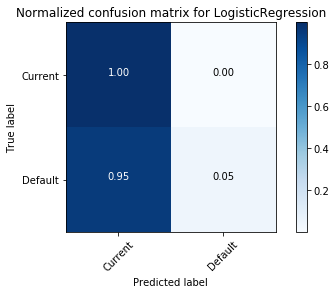

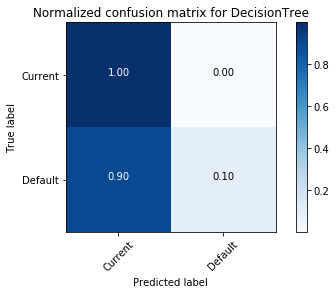

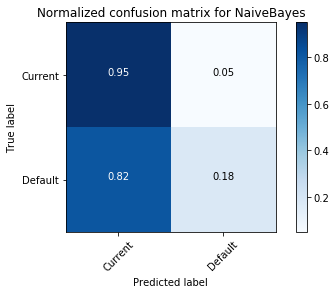

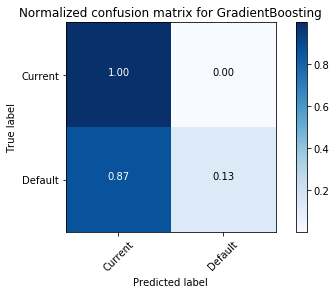

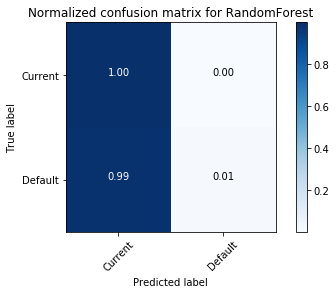

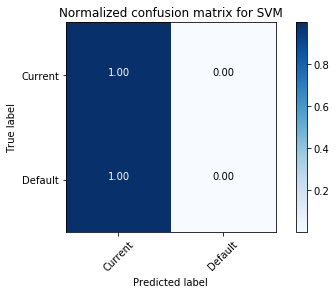

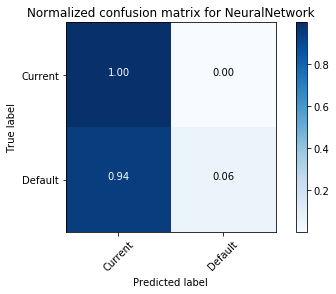

In [91]:
## Plot confusion matrix
class_names = ["Current","Default"]

for method in clfs.keys():
    # normalized confusion matrix
    plot_confusion_matrix(conf_matrix[method], classes=class_names, normalize=True,title='Normalized confusion matrix for '+method)
    

#### PREPARE MODELS USING STATSMODEL PACKAGE

sklearn does not give model details to understand which features are useful for additional insight.
I use statsmodel to study Linear and Logistic Regression models to understand which features are important.

In [93]:
## Use statsmodels Logistic Regression to get model coefs and  

import statsmodels.discrete.discrete_model as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

model = sm.Logit(y_train, X_train)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.686785
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               544000
Model:                          Logit   Df Residuals:                   543979
Method:                           MLE   Df Model:                           20
Date:                Mon, 12 Feb 2018   Pseudo R-squ.:                  -2.311
Time:                        17:57:34   Log-Likelihood:            -3.7361e+05
converged:                       True   LL-Null:                   -1.1285e+05
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1018      0.003    -35.017      0.000      -0.108      -0.096
x2            -0.1733      0.

#### BASELINE MODEL USING FICO SCORE

For comparison purposes, I use a single-factor model (using only the FICO score) to predict borrower default.

While big banks have the resources to build better models, other lenders especially in the luxury good rental
sector use simpler models like the single-factor model to make borrower default decisions.

1030262
1030262
181334
181334
Computing LogisticRegression - Balanced 
Computing NaiveBayes - Balanced 
Computing SVM - Balanced 


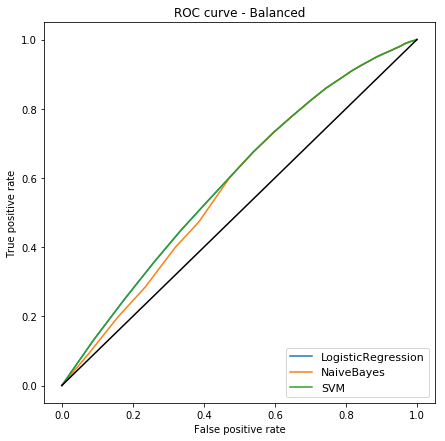

In [15]:
## 1-factor FICO score model as baseline
Xs_train = X_train[:,2:3]
Xs_test = X_test[:,2:3]
model_type = 'Balanced'
#model_type = 'Non-balanced'

print(len(Xs_train))
print(len(y_train))
print(len(Xs_test))
print(len(y_test))

clfs = {
        'LogisticRegression' : LogisticRegression(),
        'NaiveBayes': GaussianNB(),
        'SVM': LinearSVC(C=1.0),
        }

models_report_1f, conf_matrix_1f = run_models(Xs_train, y_train, Xs_test, y_test, clfs, model_type)

In [16]:
models_report_1f

,Model,Matthews_CorrCoef,Roc_Auc_Score,Precision,Recall,F1,Model_Type
0,LogisticRegression,0.061382,0.590650,0.066174,0.674387,0.120522,Balanced
1,NaiveBayes,0.061067,0.578819,0.062436,0.823245,0.116068,Balanced
2,SVM,0.061382,0.590650,0.066174,0.674387,0.120522,Balanced


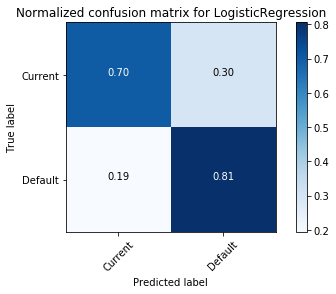

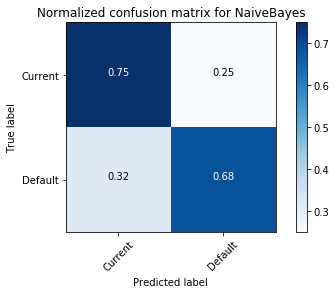

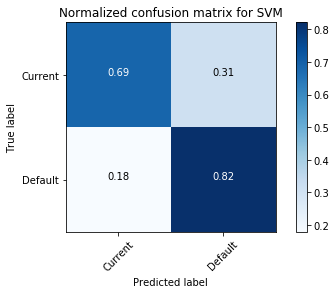

In [19]:
## Plot confusion matrix
class_names = ["Current","Default"]

for method in clfs.keys():
    # normalized confusion matrix
    plot_confusion_matrix(conf_matrix[method], classes=class_names, normalize=True,title='Normalized confusion matrix for '+method)
    